In [ ]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from adjustText import adjust_text

import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

# Load unseen-species model data
#path = 'unseen_species_model/unseen_species_model.csv'
#path = 'unseen_species_model/unseen_species_model_no_occupation.csv'


path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

db_extract_path = '../2-cultura_database_extract/db_extract'

df_cultura_original = pd.read_csv(path, index_col = [0])
df_individuals = pd.read_csv(db_extract_path + '/df_individuals_score.csv', index_col = [0])
df_works = pd.read_csv(db_extract_path + '/df_indi__work>2.csv', index_col=[0])


#df_cultura_original = df_cultura_original.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura_original['N_est'] = df_cultura_original['f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_min']  =  df_cultura_original['min_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_max']  =  df_cultura_original['max_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual

df_cultura = df_cultura_original.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

df_save = df_cultura.copy()
df_save["N_est_log"] = np.log(df_save["N_est"])
df_save["N_est_log_std"] = df_save["N_est_log"] / df_save["N_est_log"].mean()
df_save = df_save.drop(['score'], axis=1)
# df_save.to_csv('df_indicators_hdi/data_for_regression/cpm.csv')
# df_save

In [2]:
# Load individuals Data

df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)


df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']

# Define a function to rename regions
def rename_region(region):
    if region in ['Arabic world', 'Persian world']:
        return 'MENA'
    else:
        return 'Other'

# ADD MENA
new_df = df_cultura.copy()
# Apply the function to create a new 'Region Group' column
new_df['region_name'] = new_df['region_name'].apply(rename_region)

# Group by the new 'Region Group' and 'decade' columns, then sum the other columns
new_df = new_df.groupby(['region_name', 'decade']).sum().reset_index()

# Now concatenate the aggregated data back to the original dataset
df_cultura = pd.concat([new_df, df_cultura], ignore_index=True)


df_individuals_bis = df_individuals.copy()
df_individuals_bis['region_name']=df_individuals_bis['region_name'].apply(rename_region)
df_individuals = pd.concat([df_individuals, df_individuals_bis], ignore_index=True)


regions_eu = ['Latin World',
'Portugal',
'Italy',
#  'Greek World',
'Spain',
'Nordic countries',
'German world',
'Low countries',
'France',
'United Kingdom']

df_europe= df_cultura[df_cultura['region_name'].isin(regions_eu)]
df_europe['region_name'] = 'Western Europe'

df_cultura = pd.concat([df_cultura, df_europe])


df_individuals_europe = df_individuals[df_individuals['region_name'].isin(regions_eu)]
df_individuals =  pd.concat([df_individuals, df_individuals_europe])

### Make function

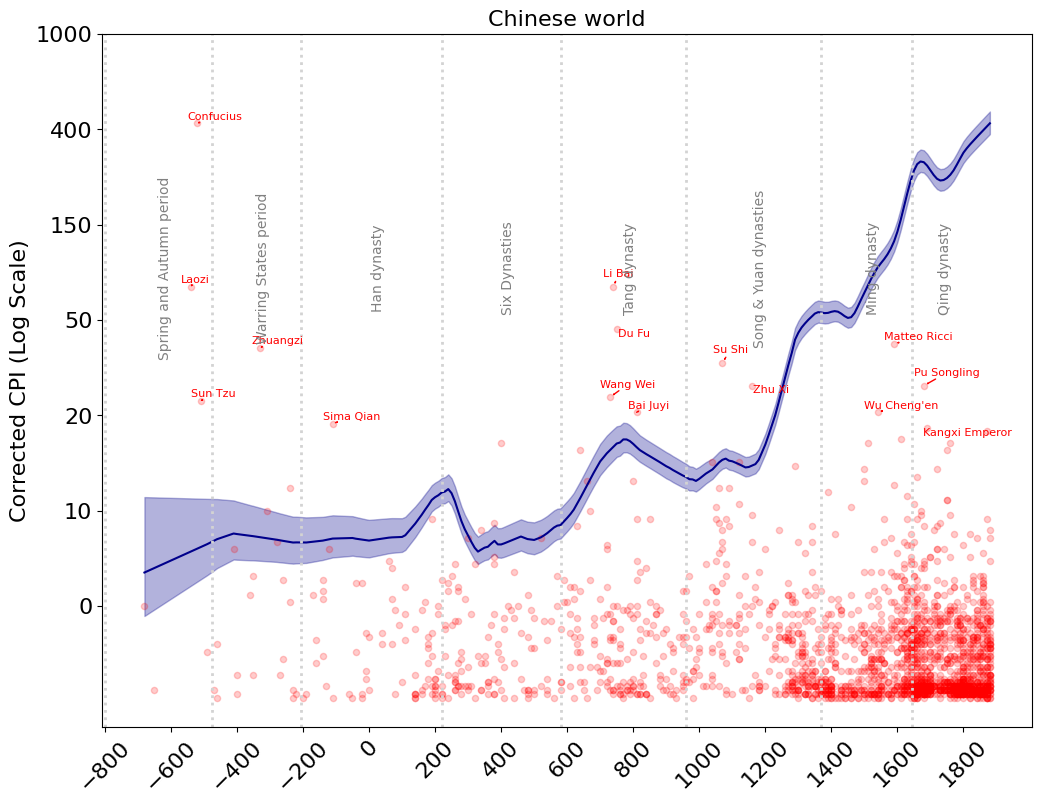

In [3]:
# Define a custom rounding function
def custom_round(x):
    if x >= 100000:
        return np.round(x, -5)  # Round to nearest 100000
    elif x >= 10000:
        return np.round(x, -4)  # Round to nearest 10000
    elif x >= 1000:
        return np.round(x, -3)  # Round to nearest 1000
    else:
        return np.round(x, -1)  # Round to nearest 10


def plot_figure(region_name, 
                max_year, 
                min_year, 
                period_data, 
                year_step = 200, 
                plot_names = True, 
                frac = 0.1, 
                top_n_individuals = 15,
                plot_bars = False,
                plot_original_trend = False,
                yticks = [5, 10, 50, 100, 500, 1000, 2000],
                fifty = False,
                log=True,
                legend=False,
                plot_name_names=True,
                fontsize_title=16,
                fontsize_axis_ticks = 16,
                fontsize_axis_name = 16):


    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name])]
        

    df = df_cultura[df_cultura['region_name'].isin([region_name])]

    if fifty:
            df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
            df = df.groupby(['region_name', 'decade']).sum().reset_index()



    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    if log:
        df['N_est'] = np.log(df['N_est'])  # Applying log transformation
        df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
        df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
        df['score'] = np.log(df['score'])  # Max bound log

    # Define your color scheme
    colors = {
        region_name: "#00008b",
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = sm.nonparametric.lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = sm.nonparametric.lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = sm.nonparametric.lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label ='Corrected Index', color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing

            smoothed = sm.nonparametric.lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)
            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label='Original Index', color='#006400', linewidth=3, linestyle='-')



    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)


            if plot_name_names:

                # Texts for top 15
                for _, row in top_individuals.iterrows():
                    score_normalized = (row['score'] / max_global_score) * max_n_est
                    text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                                ha='center', va='bottom', color='red',fontsize=8)
                    texts.append(text)

                # Use adjust_text for the current region with the corresponding arrow color
                adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.1, zorder=2)


   
    yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels

    # Get current y-axis ticks (which are in log scale)


    if log:
        ticks_log = ax.get_yticks()

        # Calculate the original values from the log scale ticks
        ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

        # Round to the nearest 10

        ticks_rounded = [custom_round(tick) for tick in ticks_original]

        #ticks_rounded = np.around(ticks_original / 10) * 10

        # Remove duplicates, keeping only the last occurrence
        unique_ticks = {}
        for tick, original in zip(ticks_rounded, ticks_log):
            unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

        # Now, set the ticks and labels, skipping duplicates
        final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
        ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
        ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=fontsize_axis_ticks)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=fontsize_axis_ticks)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    if log:
        ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = fontsize_axis_name)
    else:
         ax.set_ylabel('Corrected CPI', fontsize = fontsize_axis_name)
    ax.set_title(region_name, fontsize = fontsize_title)
    
    if plot_original_trend:
        ax.legend()  # This will add the legend with labels as specified in plot commands
    else:
        ax.legend().remove()  # This conditionally removes the legend
    
    plt.show()


region_name = 'Chinese world'
min_year = -800
max_year = 1880


chinese_period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}


plot_figure(region_name, max_year, min_year, period_data=chinese_period_data, year_step = 200, plot_original_trend = False, fifty=False, frac=0.1)



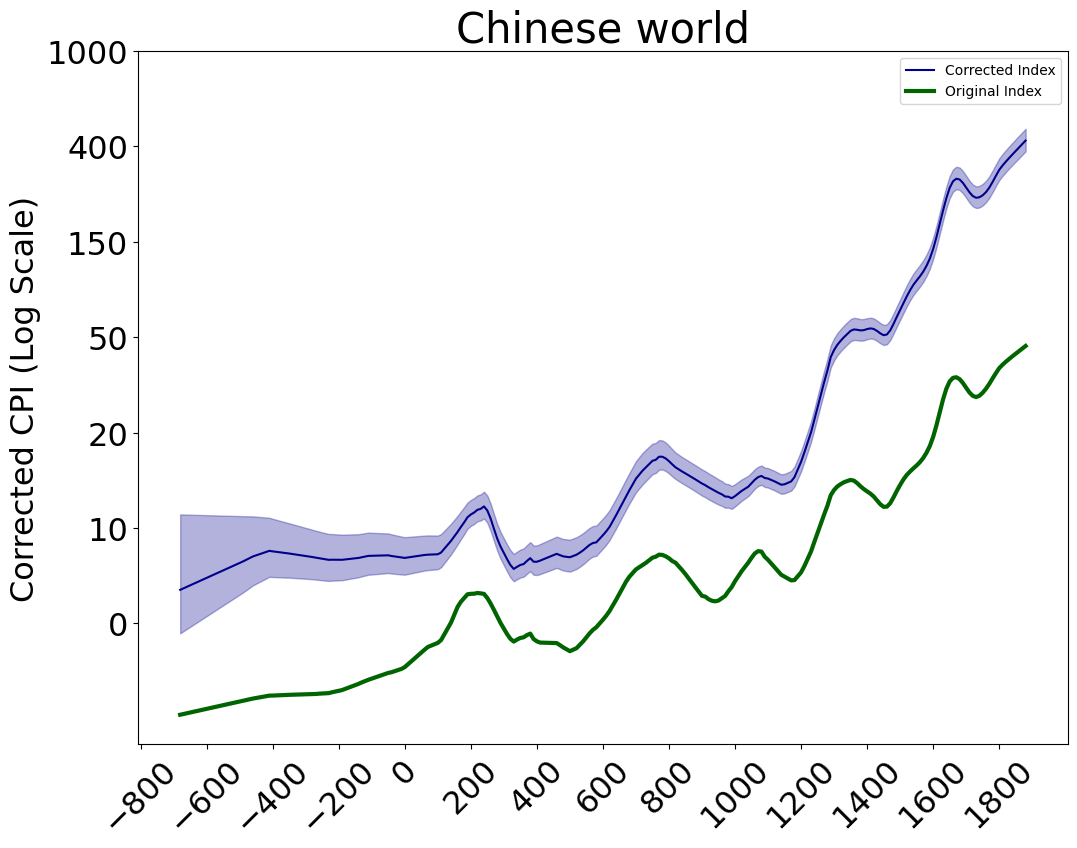

In [4]:
plot_figure(region_name, max_year, min_year, period_data=None, 
            year_step = 200, plot_original_trend = True, fifty=False, 
            frac=0.1, plot_name_names=False, plot_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

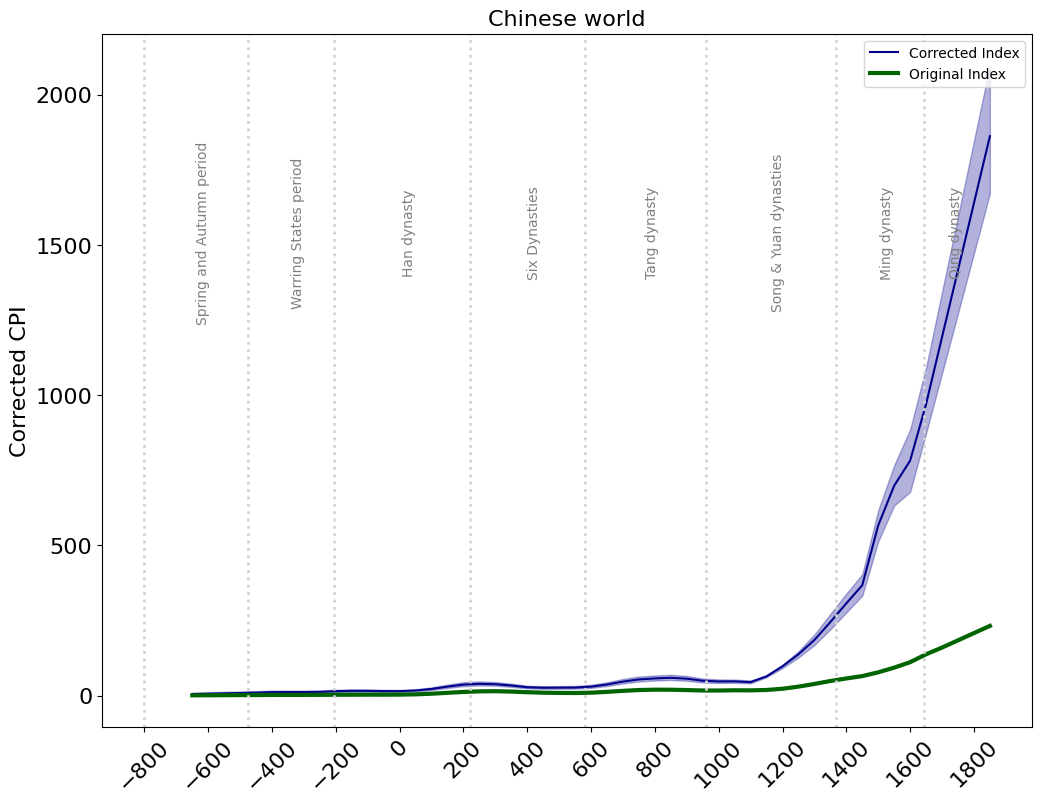

In [5]:
plot_figure(region_name, max_year, min_year,
             period_data=chinese_period_data, 
             year_step = 200, 
             plot_original_trend = True, fifty=True, frac=0.2, plot_names = False, log=False, legend=True)


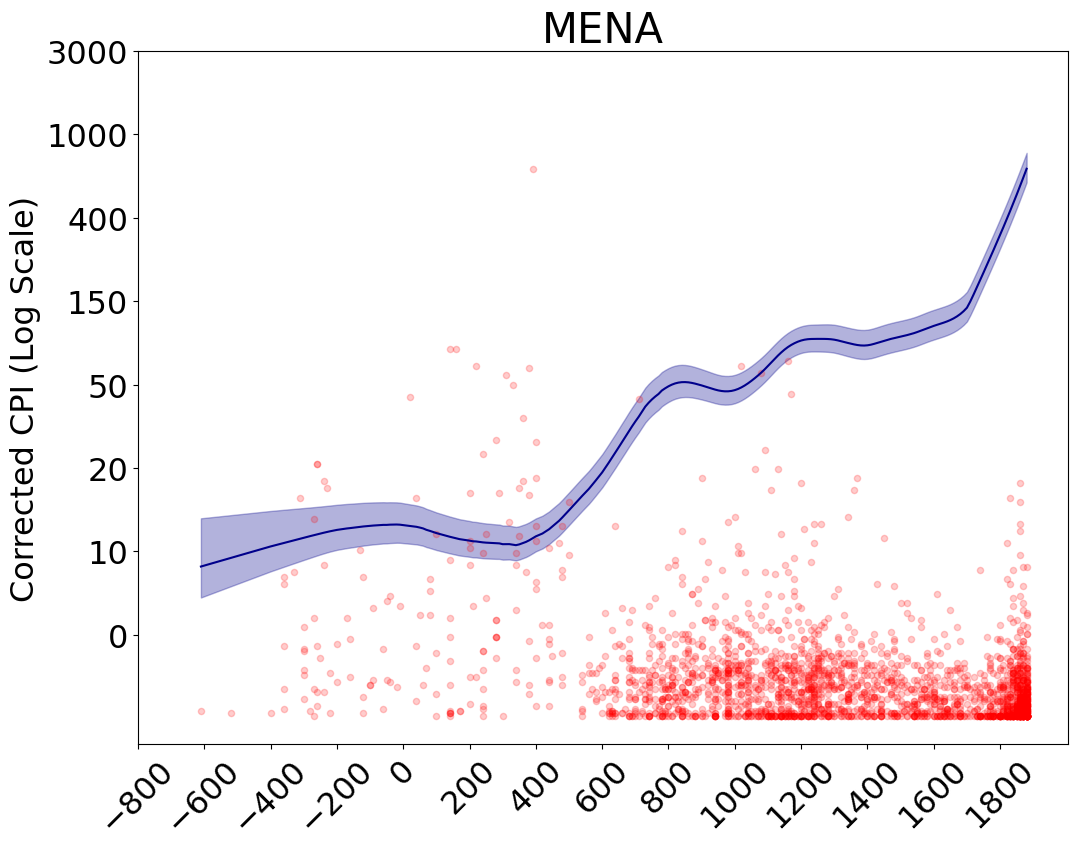

In [6]:
plot_figure(region_name = 'MENA', min_year = -800, 
            max_year = 1880, period_data = None,  year_step = 200, frac=0.2, 
            plot_bars = False, plot_original_trend = False, fifty=False, plot_name_names = False,
             fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

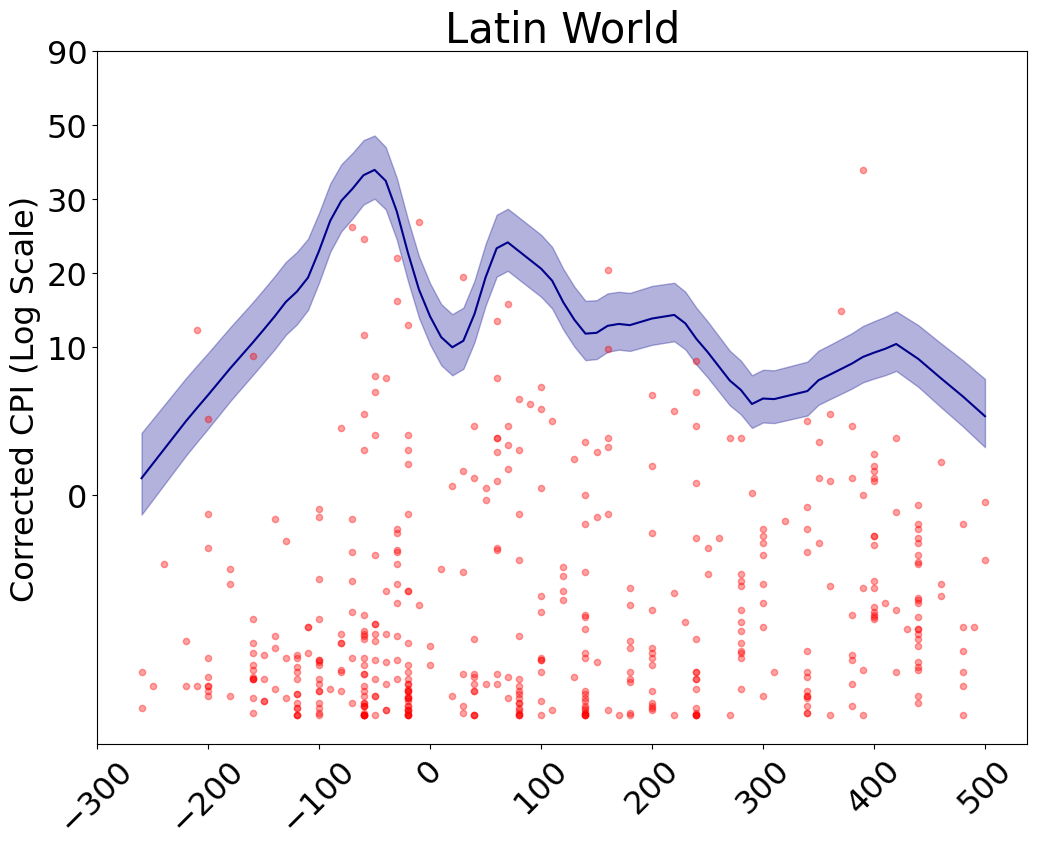

In [7]:
plot_figure(region_name = 'Latin World', min_year = -300, 
            max_year = 500, period_data = None,  year_step = 100, frac=0.2, 
            plot_bars = False, plot_original_trend = False, fifty=False, plot_name_names = False,
             fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

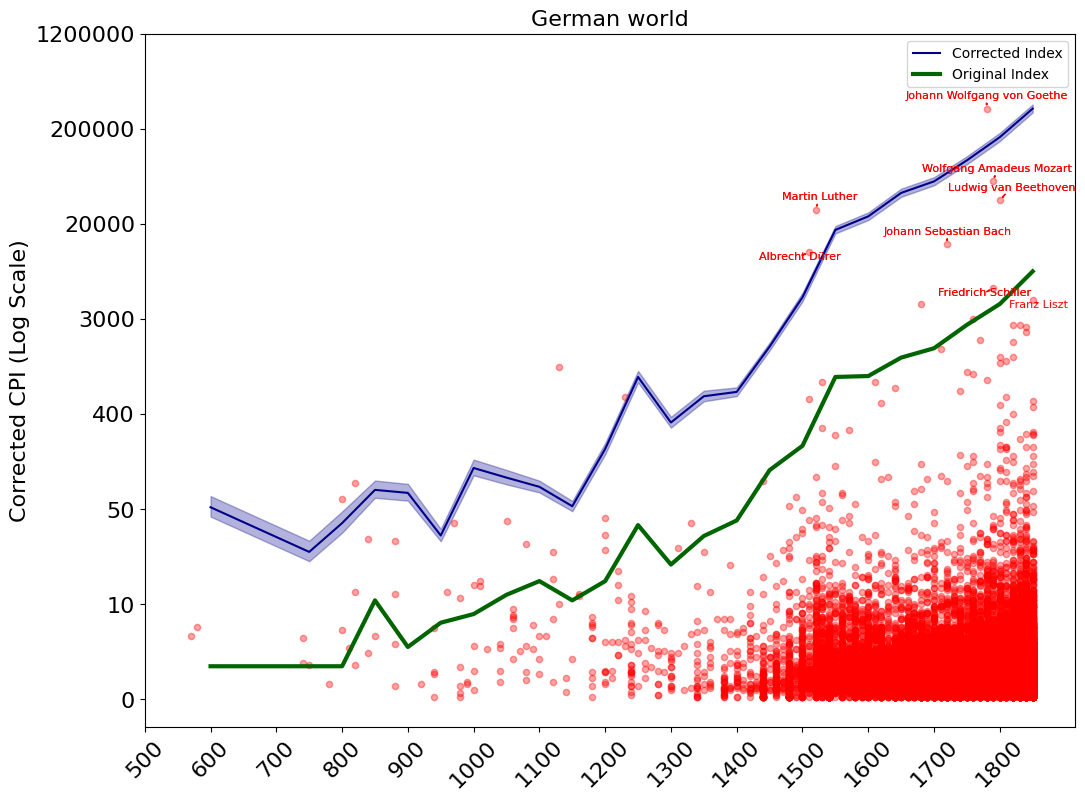

In [8]:
plot_figure(region_name = 'German world', min_year = 500, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.15, plot_bars = False, plot_original_trend = True, fifty=True)

In [9]:
list(set(df_cultura['region_name']))

['German world',
 'Indian world',
 'Nordic countries',
 'Northwestern Europe',
 'Korea',
 'Western Europe',
 'Southern Japan',
 'Central Europe',
 'United Kingdom',
 'Chinese world',
 'Persian world',
 'Latin World',
 'Greek World',
 'Portugal',
 'Japan',
 'Southern China',
 'Other',
 'Low countries',
 'Spain',
 'Italy',
 'East Slavic',
 'Northern China',
 'Northern Japan',
 'Southwestern Europe',
 'MENA',
 'Arabic world',
 'France']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx an

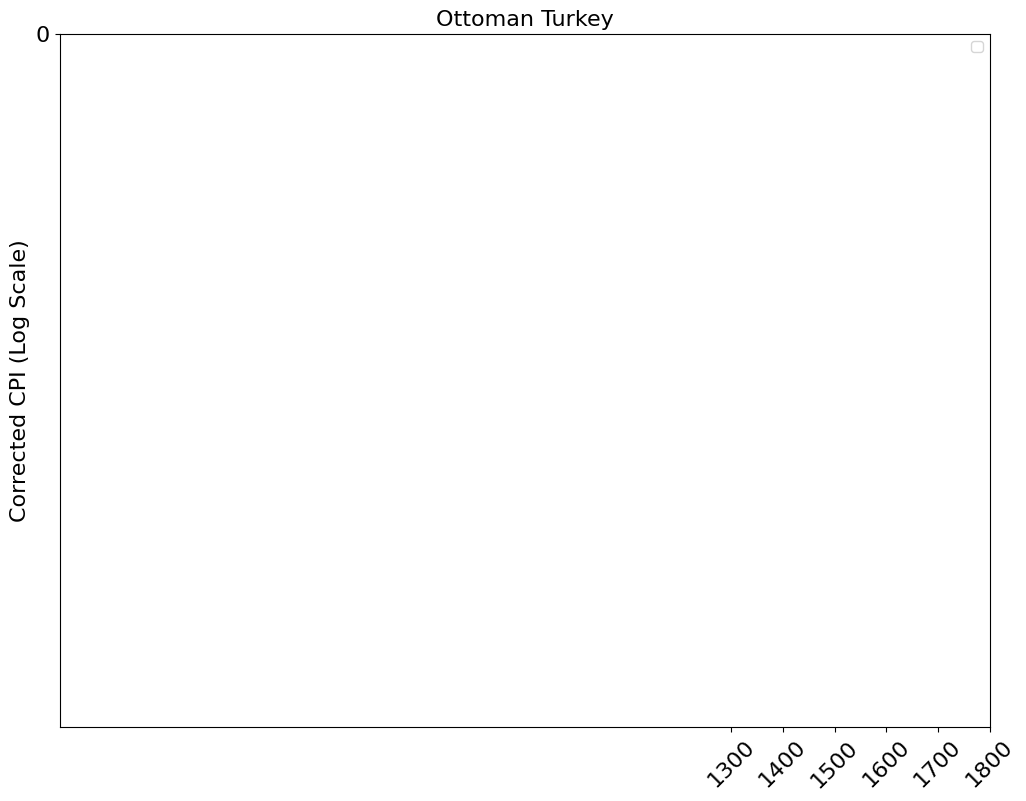

In [10]:
plot_figure(region_name = 'Ottoman Turkey', min_year = 1300, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.2, plot_bars = False, plot_original_trend = True, fifty=True)

In [11]:
df_individuals[df_individuals['region_name']=='Nordic countries'].sort_values('decade')

individual_wikidata_id  productive_year  decade  \
77787                Q1402591            586.0     590   
77787                Q1402591            586.0     590   
100560              Q15661609            829.0     830   
100560              Q15661609            829.0     830   
246074               Q2628262            845.0     840   
...                       ...              ...     ...   
442885               Q5743727           1884.0    1880   
443089               Q5749303           1878.0    1880   
443261               Q5754400           1879.0    1880   
216408              Q21717269           1878.0    1880   
17022              Q106489671           1880.0    1880   

                   individual_name  score       region_name  
77787                      Ohthere      3  Nordic countries  
77787                      Ohthere      3  Nordic countries  
100560       Brúni hvíti Háreksson      1  Nordic countries  
100560       Brúni hvíti Háreksson      1  Nordic countries  
246074                     Hastein      5  Nordic countries  
...                            ...    ...               ...  
442885             J.A. Fridericia     23  Nordic countries  
443089  Carl Gustaf Hugo Thedenius      6  Nordic countries  
443261       Wilhelm von Gegerfelt     36  Nordic countries  
216408       Carl Frederick Wandel     15  Nordic countries  
17022                Maria Erikson      3  Nordic countries  

[16508 rows x 6 columns]

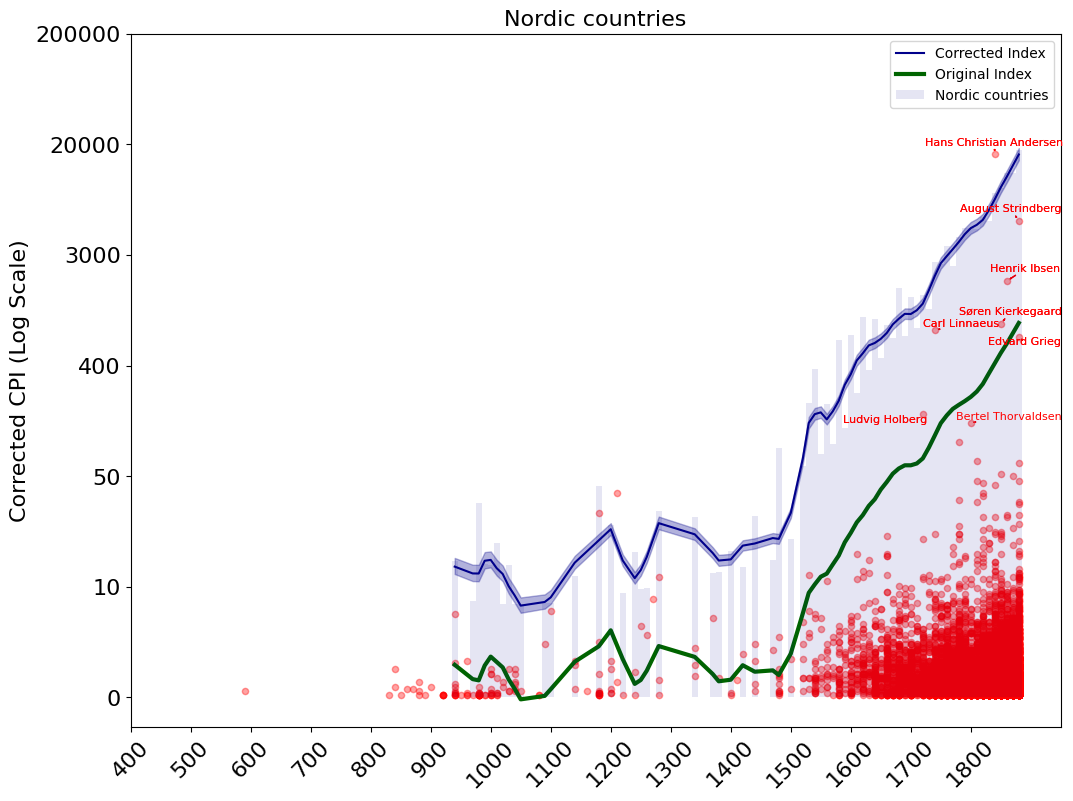

In [12]:
plot_figure(region_name = 'Nordic countries', min_year = 400, max_year = 1880,period_data = None,  year_step = 100, frac=0.1, plot_bars = True,  plot_original_trend = True,)

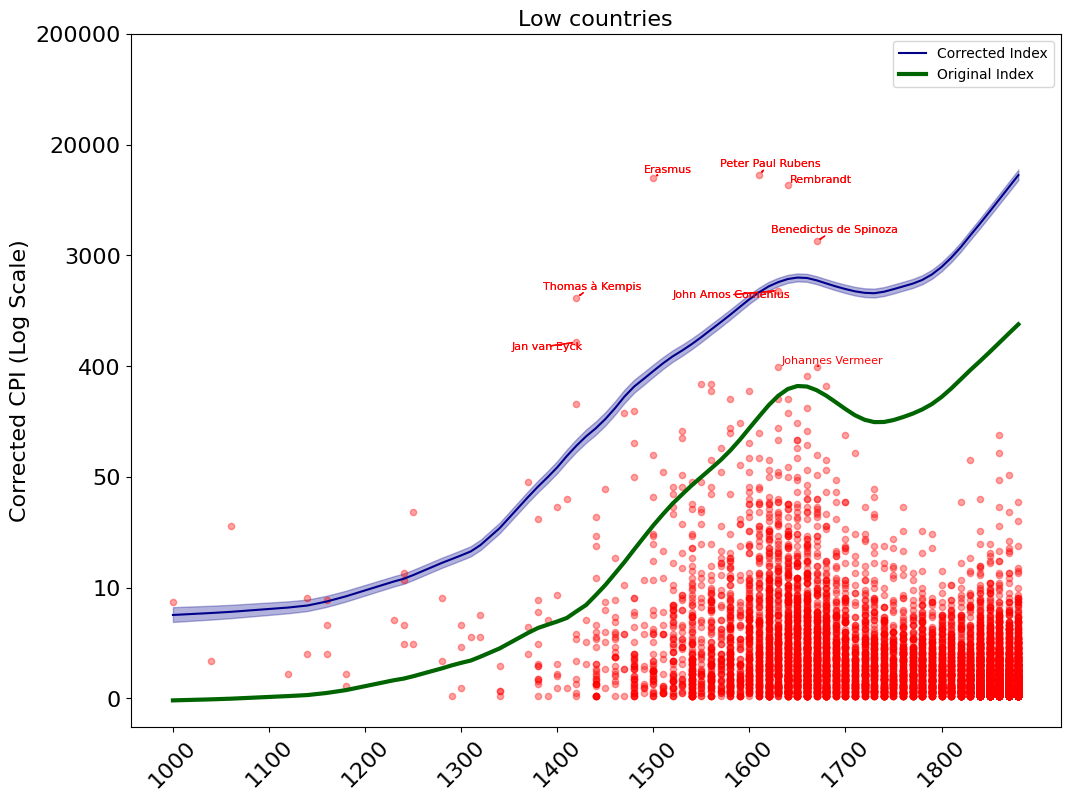

In [13]:
plot_figure(region_name = 'Low countries', min_year = 1000, max_year = 1880,period_data = None,  year_step = 100, frac=0.2,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

In [14]:
list(set(df_cultura.region_name))

['German world',
 'Indian world',
 'Nordic countries',
 'Northwestern Europe',
 'Korea',
 'Western Europe',
 'Southern Japan',
 'Central Europe',
 'United Kingdom',
 'Chinese world',
 'Persian world',
 'Latin World',
 'Greek World',
 'Portugal',
 'Japan',
 'Southern China',
 'Other',
 'Low countries',
 'Spain',
 'Italy',
 'East Slavic',
 'Northern China',
 'Northern Japan',
 'Southwestern Europe',
 'MENA',
 'Arabic world',
 'France']

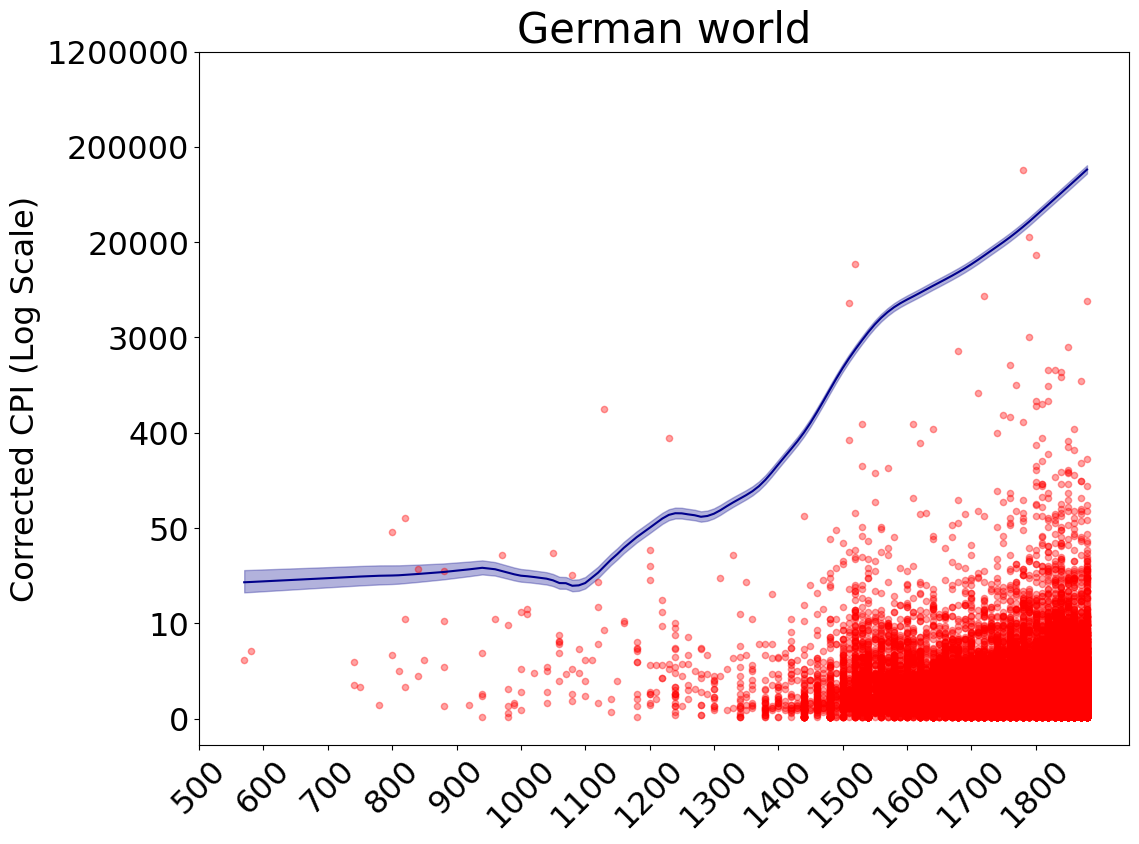

In [15]:
plot_figure(region_name = 'German world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2,    
                fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

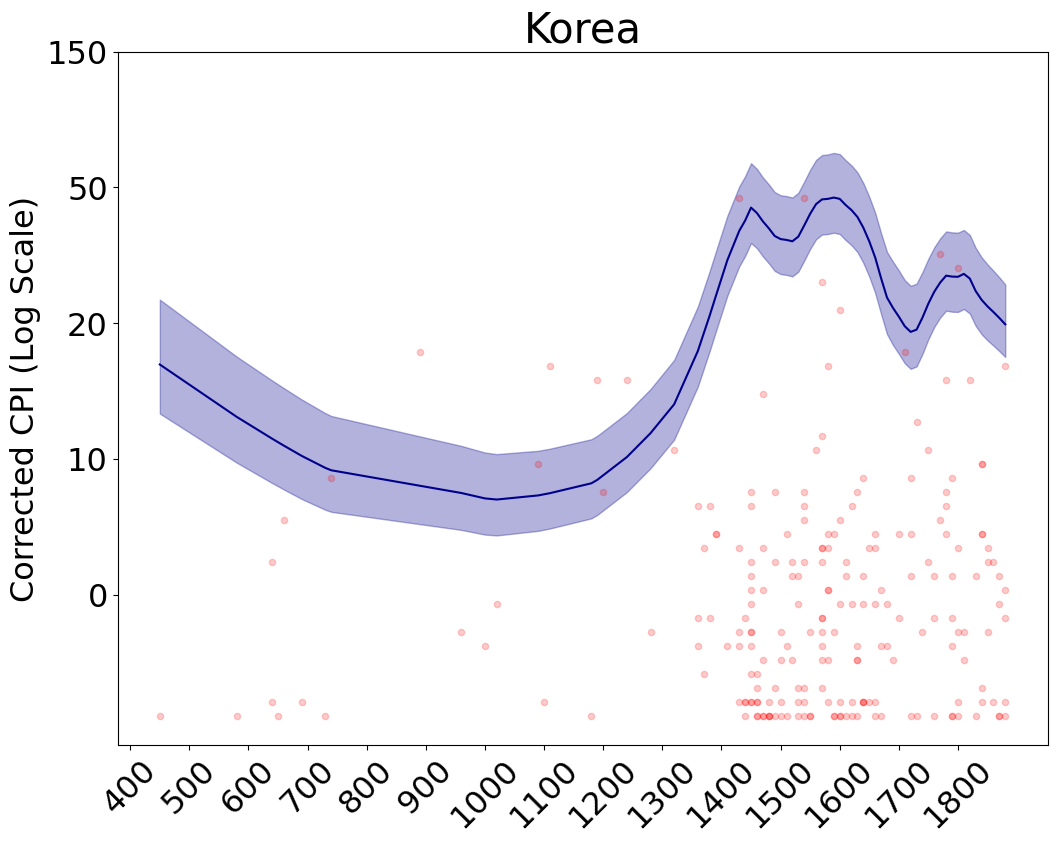

In [16]:
plot_figure(region_name = 'Korea', min_year = 400, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2, fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

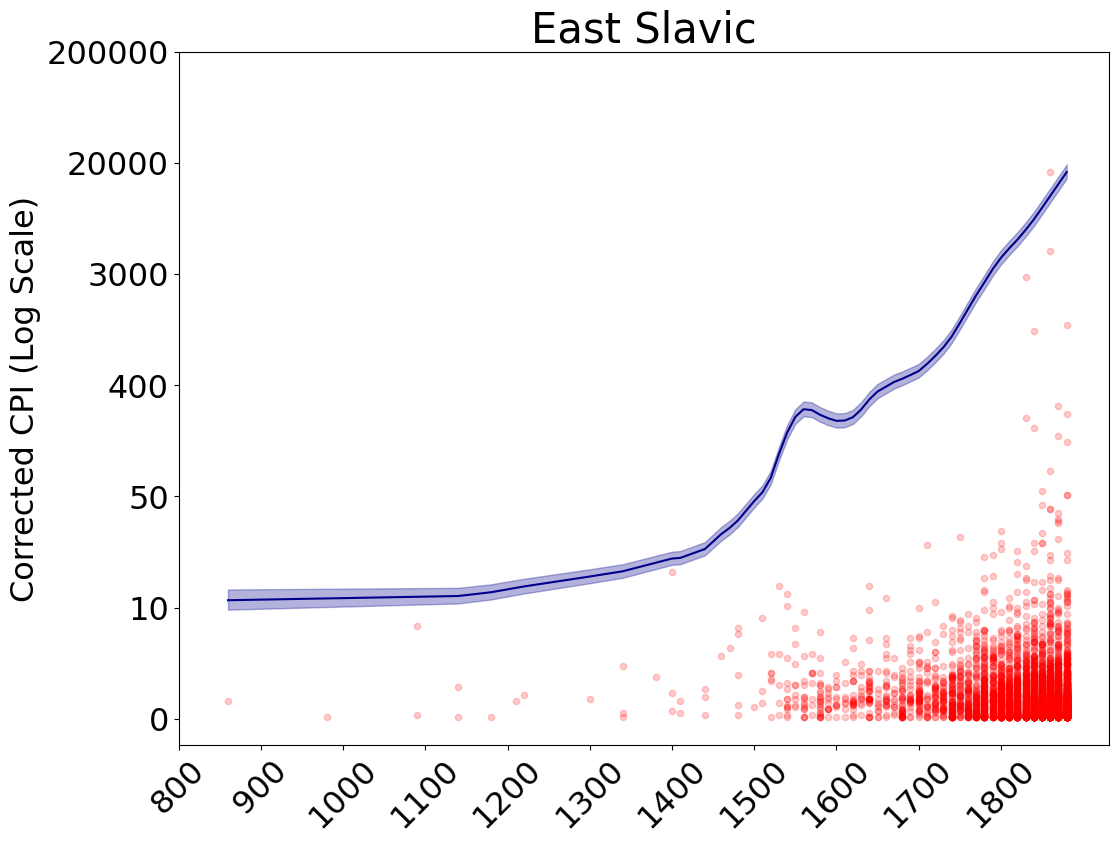

In [17]:
plot_figure(region_name = 'East Slavic', min_year = 800, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

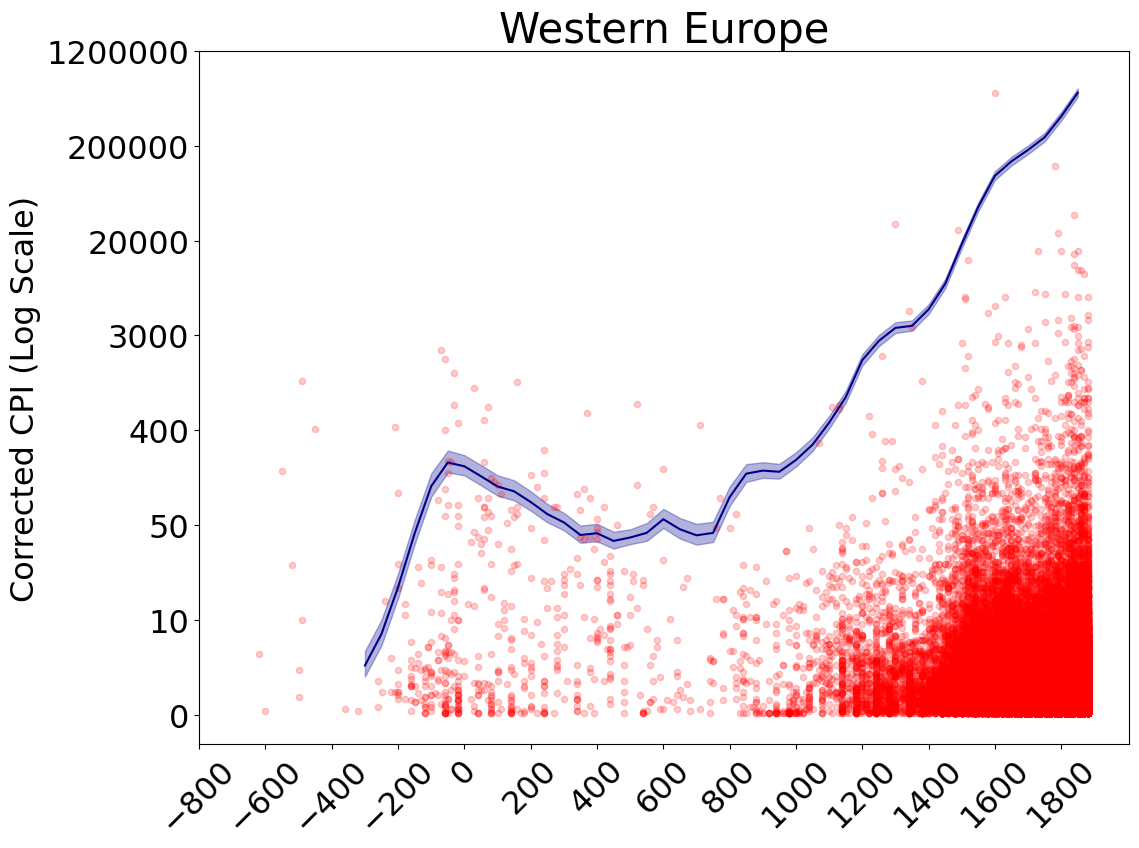

In [18]:
plot_figure(region_name = 'Western Europe', min_year = -800, max_year = 1880,period_data = None,  year_step = 200, 
            plot_original_trend = False, plot_name_names=False, fifty=True,
            fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

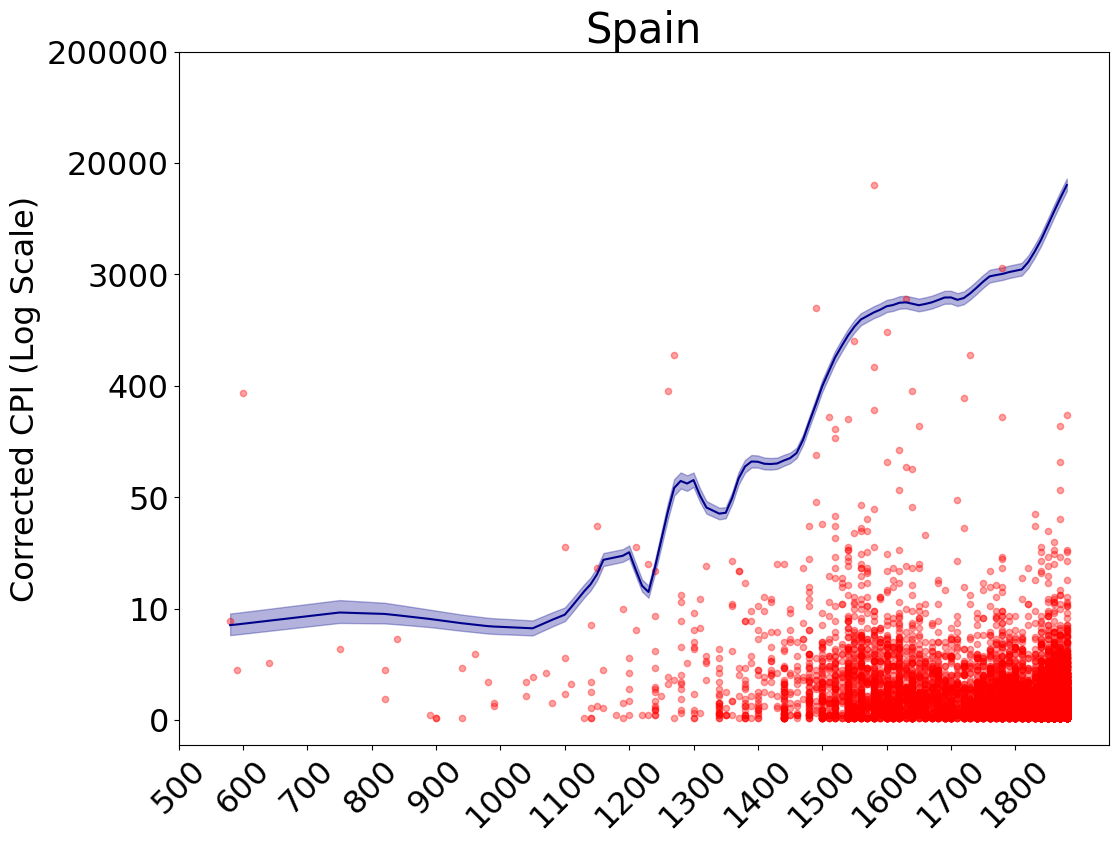

In [19]:
plot_figure(region_name = 'Spain', min_year = 500, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False,
            fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

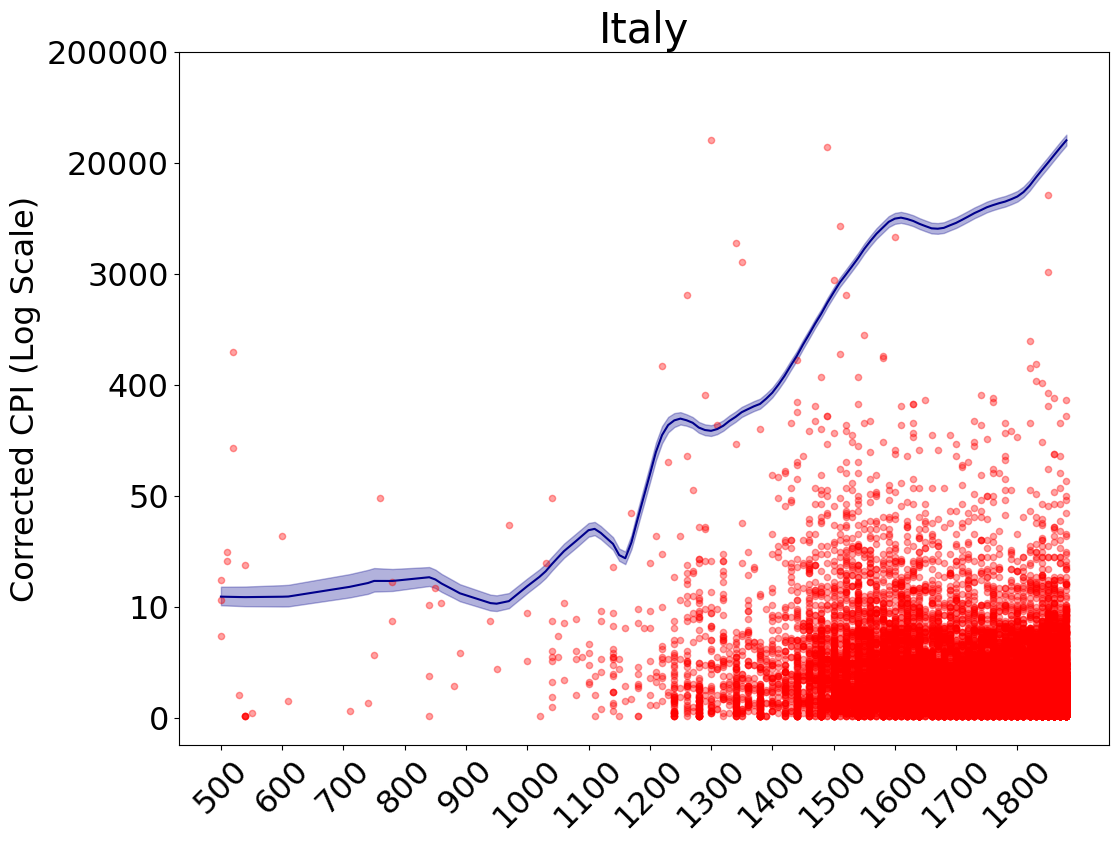

In [20]:
plot_figure(region_name = 'Italy', min_year = 500, max_year = 1880,
            period_data = None,  year_step = 100,  plot_original_trend = False, plot_name_names=False, 
            fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

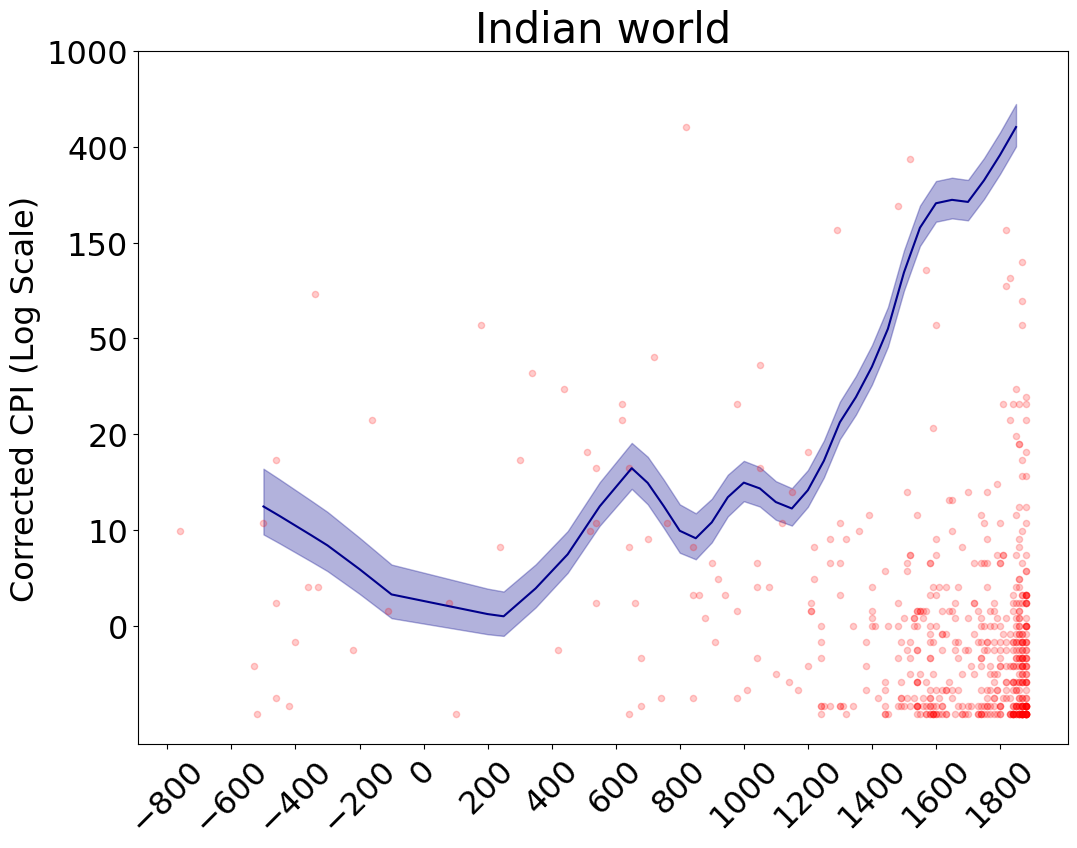

In [21]:
plot_figure(region_name = 'Indian world', min_year = -800, max_year = 1880,
            period_data = None,  fifty = True, year_step = 200, 
            plot_original_trend = False, frac=0.2,plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

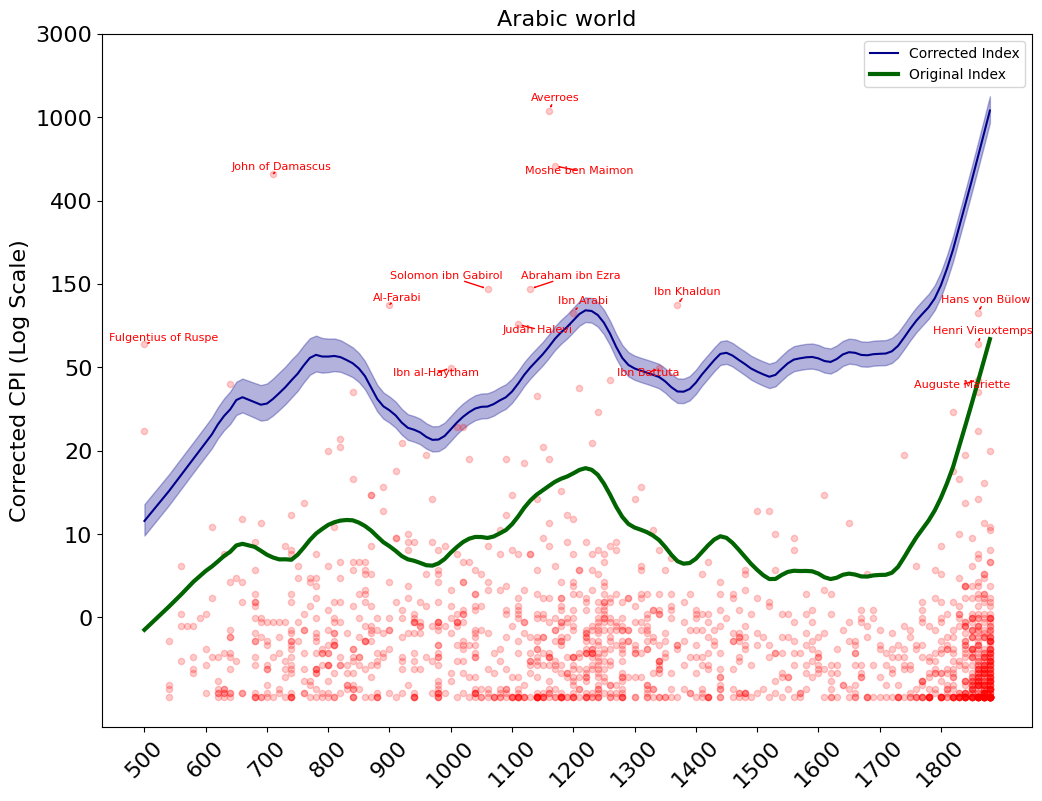

In [22]:
plot_figure(region_name = 'Arabic world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True)

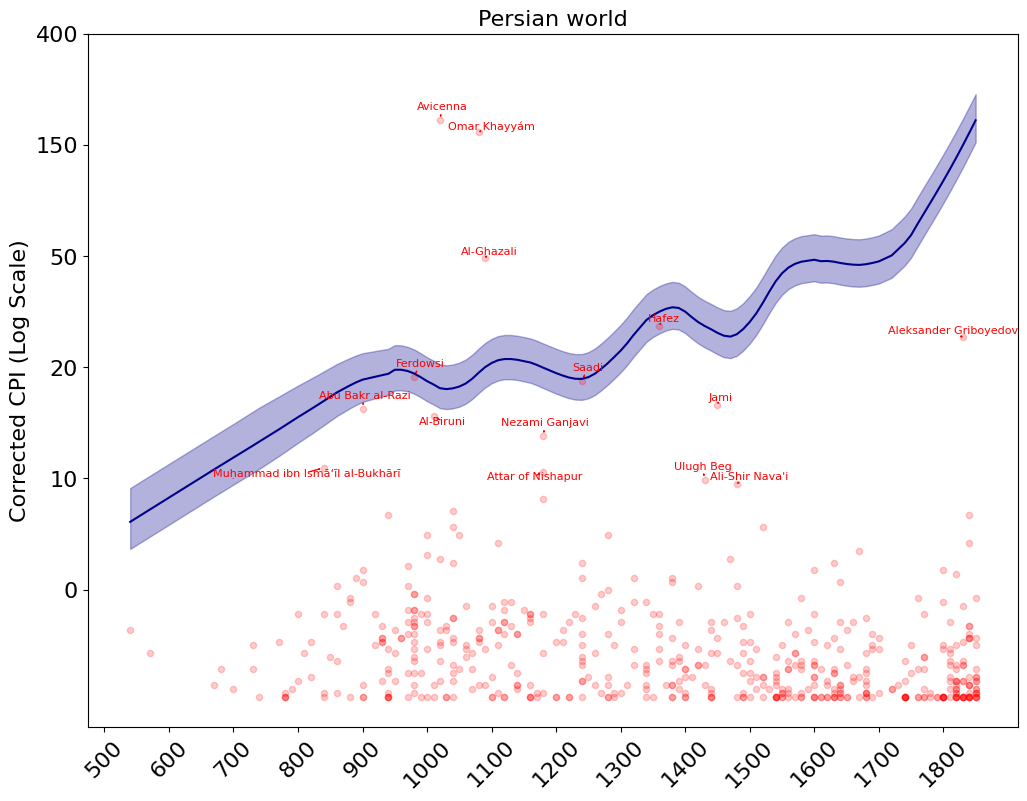

In [23]:
plot_figure(region_name = 'Persian world', min_year = 500, max_year = 1850,period_data = None,  year_step = 100, fifty=False, frac=0.2)

In [24]:
japanese_period_data = {
    "x_intercepts": [
        [0, 300],
        [300, 538],
        [538, 710],
        [710, 794],
        [794, 1185],
        [1185, 1333],
        [1333, 1600],
        [1600, 1800]
    ],
    "labels": [
        "Yayoi period",
        "Kofun period",
        "Asuka period",
        "Nara period",
        "Heian period",
        "Kamakura period",
        "Muromachi period",
        "Edo period"
    ]
}

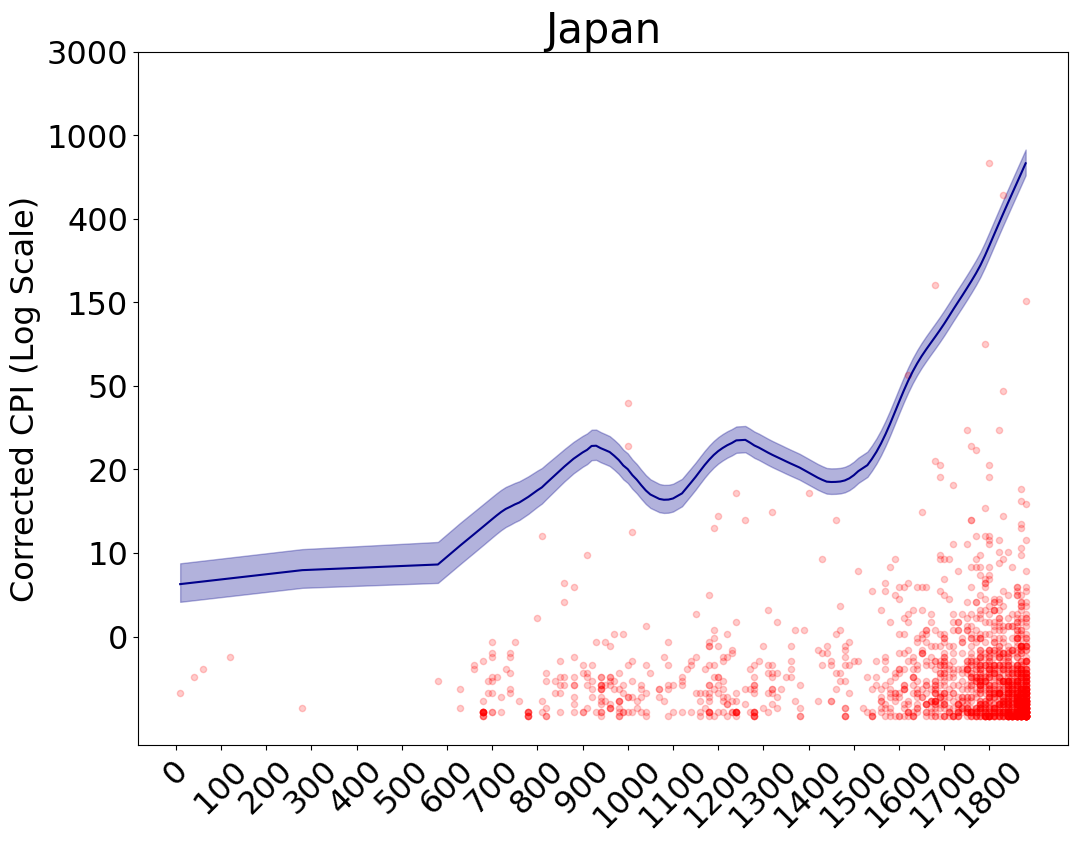

In [25]:
plot_figure(region_name = 'Japan', min_year = 0, max_year = 1880,period_data = None,  year_step = 100,  
            plot_original_trend = False, frac = 0.2, plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

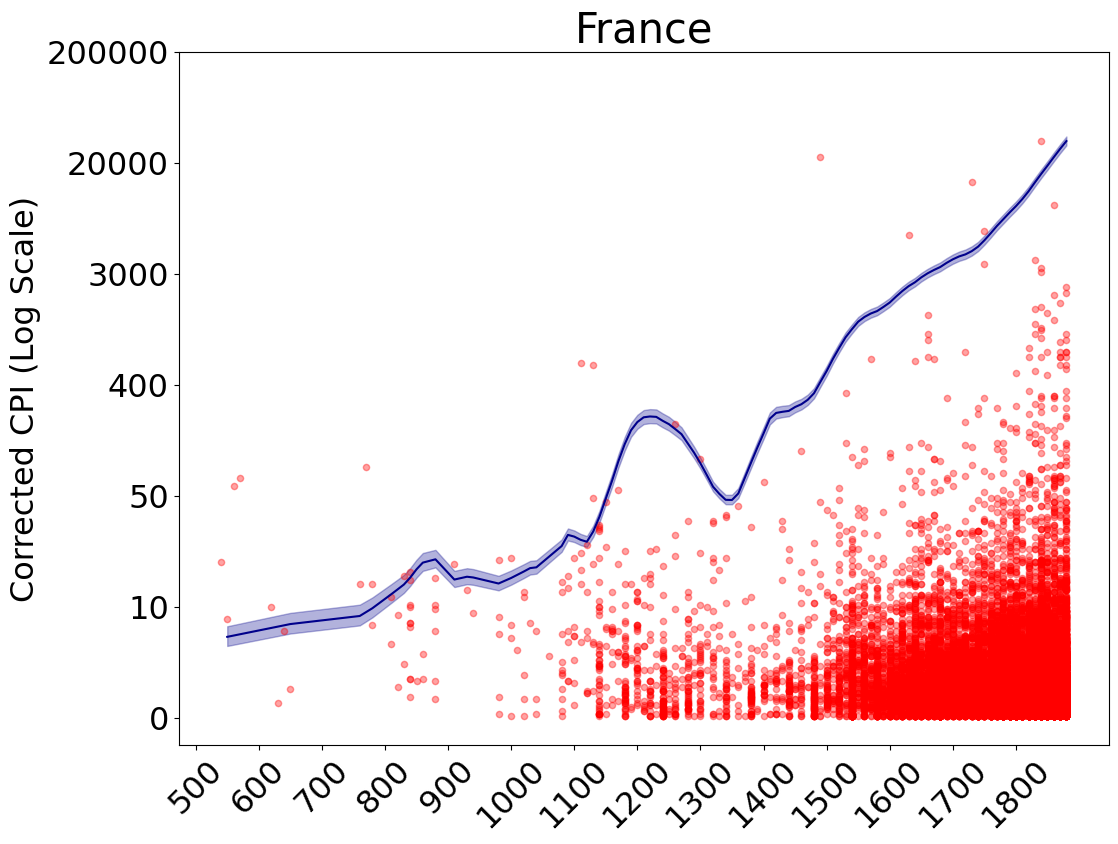

In [26]:
plot_figure(region_name = 'France', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  
            plot_original_trend = False, plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

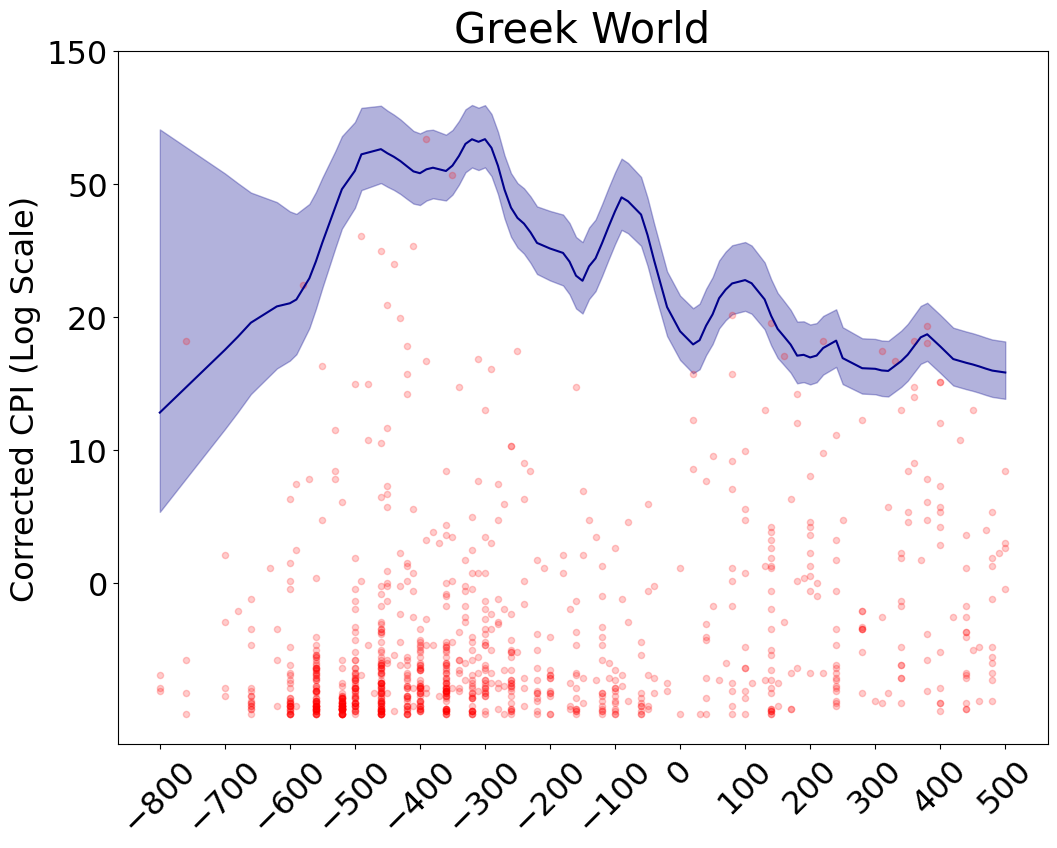

In [27]:
plot_figure(region_name = 'Greek World', min_year = -800, 
            max_year = 500,period_data = None,  year_step = 100, frac = 0.15,  
            plot_original_trend = False, plot_name_names = False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

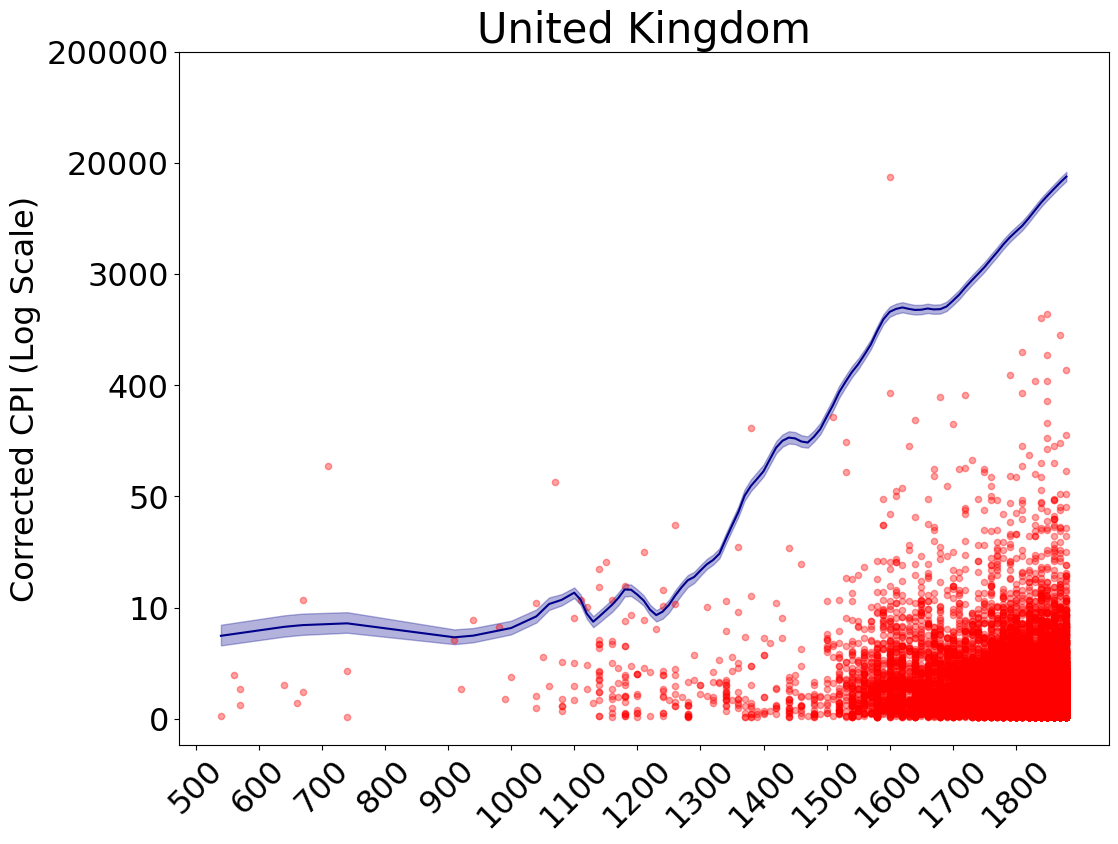

In [28]:
plot_figure(region_name = 'United Kingdom', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = False,
             plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

### Plot 2 figures

In [29]:
def plot_figures(region_name_1, 
                 region_name_2,
                    max_year, 
                    min_year, 
                    period_data, 
                    title,
                    year_step = 200, 
                    plot_names = True, 
                    frac = 0.1, 
                    top_n_individuals = 15,
                    plot_bars = False,
                    plot_original_trend = False,
                    fifty=False,
                    plot_name_names=True
                    ):




    
    df = df_cultura[df_cultura['region_name'].isin([region_name_1, region_name_2])]


    if fifty:
        df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
        df = df.groupby(['region_name', 'decade']).sum().reset_index()


    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    df['N_est'] = np.log(df['N_est'])  # Applying log transformation
    df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
    df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
    df['score'] = np.log(df['score'])  # Max bound log



    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name_1, region_name_2])]
    # Define your color scheme
    colors = {
        region_name_1: "#00bfc4",
        region_name_2: "#f8766d"
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing
            smoothed = lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

            if plot_name_names:
                # Texts for top 15
                for _, row in top_individuals.iterrows():
                    score_normalized = (row['score'] / max_global_score) * max_n_est
                    text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                                ha='center', va='bottom', color=colors[region],fontsize=8)
                    texts.append(text)

                # Use adjust_text for the current region with the corresponding arrow color
                adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.2, zorder=2)


    # # Define specific y-ticks and convert them to log scale for plotting
    # yticks = [5, 10, 50, 100, 500, 1000, 2000]
    # yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


     # Get current y-axis ticks (which are in log scale)
    ticks_log = ax.get_yticks()

    # Calculate the original values from the log scale ticks
    ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

    # Round to the nearest 10

    ticks_rounded = [custom_round(tick) for tick in ticks_original]

    #ticks_rounded = np.around(ticks_original / 10) * 10

    # Remove duplicates, keeping only the last occurrence
    unique_ticks = {}
    for tick, original in zip(ticks_rounded, ticks_log):
        unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

    # Now, set the ticks and labels, skipping duplicates
    final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
    ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
    ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.show()





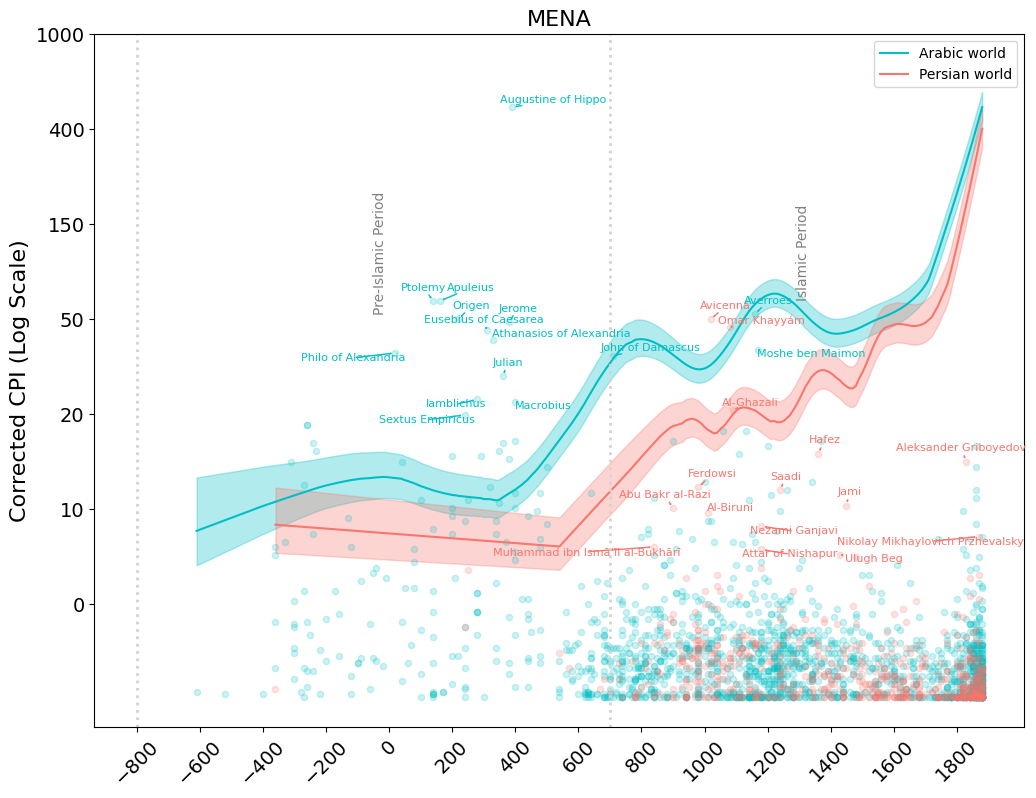

In [30]:

plot_figures(region_name_1="Arabic world", 
        region_name_2='Persian world',
            max_year = 1880, 
            min_year = -800, 
            title='MENA',
            period_data = {
            "x_intercepts": [
                [-800, 700],
                [700, 1880],
            
            ],
            "labels": [
                "Pre-Islamic Period",
                "Islamic Period",
            ]
        }, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False,
            fifty=False,
            plot_name_names=True)

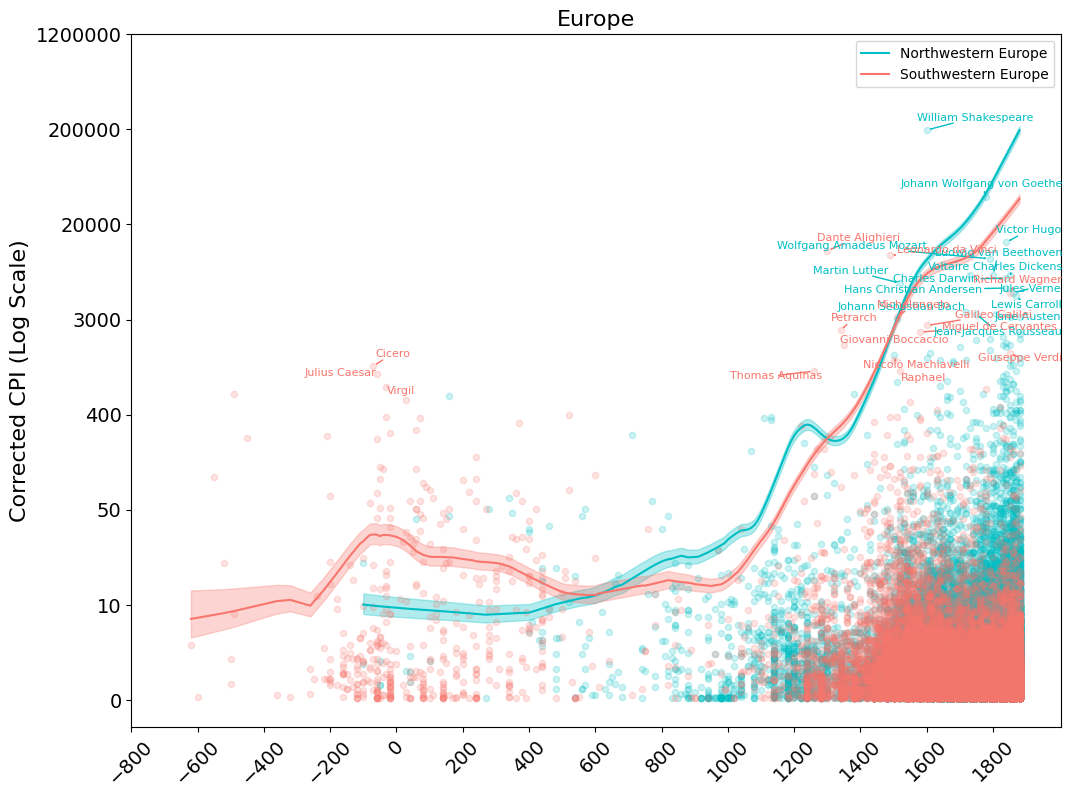

In [31]:
plot_figures(region_name_1="Northwestern Europe", 
        region_name_2='Southwestern Europe',
            max_year = 1880, 
            min_year = -800, 
            title='Europe',
            period_data = None, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.15, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, fifty = False)

In [32]:
list(set(df_cultura.region_name))

['German world',
 'Indian world',
 'Nordic countries',
 'Northwestern Europe',
 'Korea',
 'Western Europe',
 'Southern Japan',
 'Central Europe',
 'United Kingdom',
 'Chinese world',
 'Persian world',
 'Latin World',
 'Greek World',
 'Portugal',
 'Japan',
 'Southern China',
 'Other',
 'Low countries',
 'Spain',
 'Italy',
 'East Slavic',
 'Northern China',
 'Northern Japan',
 'Southwestern Europe',
 'MENA',
 'Arabic world',
 'France']

In [33]:
list(set(df_cultura.region_name))

['German world',
 'Indian world',
 'Nordic countries',
 'Northwestern Europe',
 'Korea',
 'Western Europe',
 'Southern Japan',
 'Central Europe',
 'United Kingdom',
 'Chinese world',
 'Persian world',
 'Latin World',
 'Greek World',
 'Portugal',
 'Japan',
 'Southern China',
 'Other',
 'Low countries',
 'Spain',
 'Italy',
 'East Slavic',
 'Northern China',
 'Northern Japan',
 'Southwestern Europe',
 'MENA',
 'Arabic world',
 'France']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

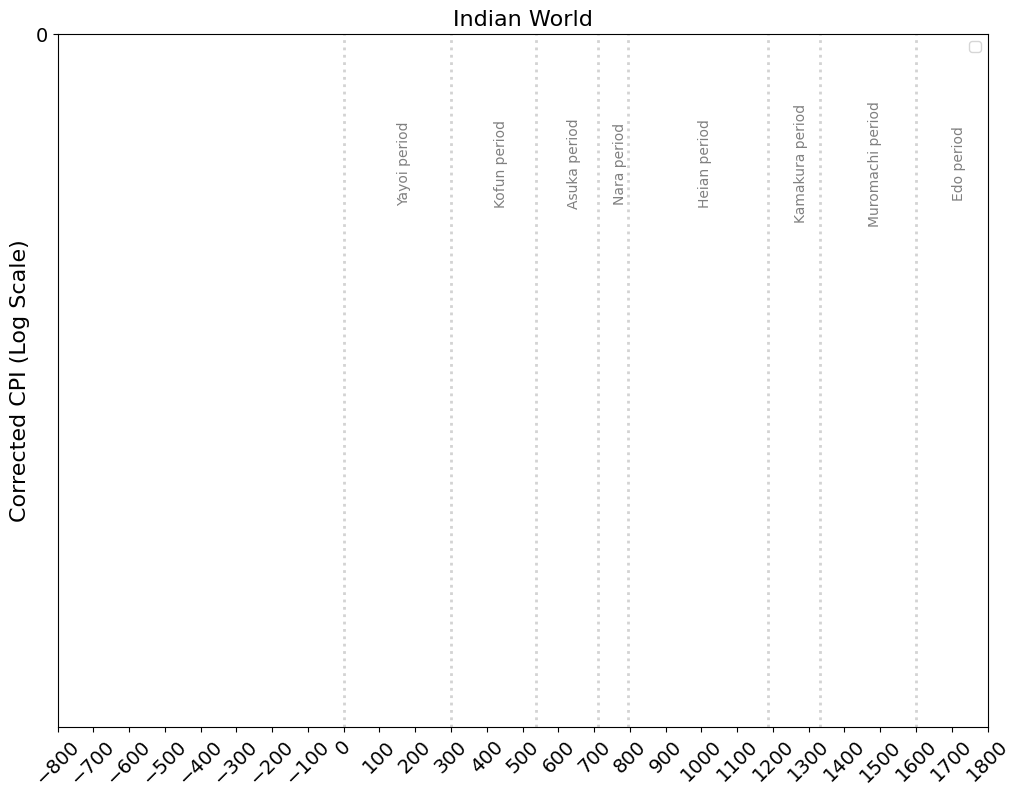

In [34]:
plot_figures(region_name_1="Southern India", 
        region_name_2="Northern India",
            max_year = 1880,
            min_year = -800, 
            title='Indian World',
            period_data =japanese_period_data, 
            year_step = 100, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = False)

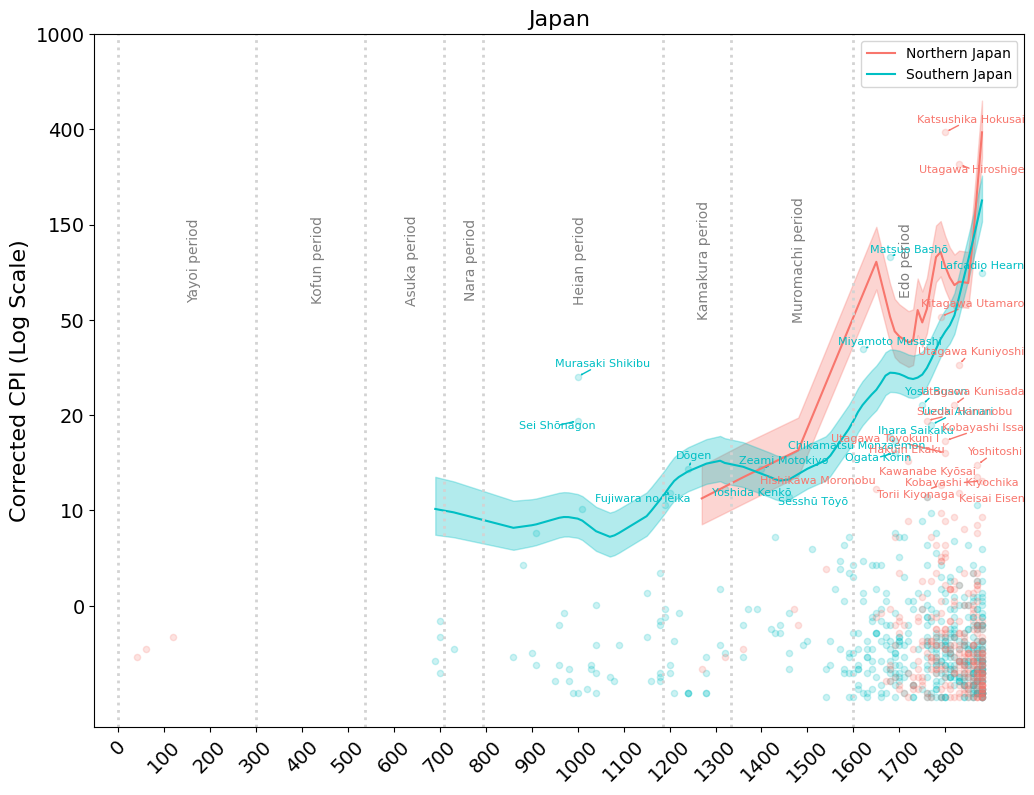

In [35]:
plot_figures(region_name_1="Southern Japan", 
        region_name_2="Northern Japan",
            max_year = 1880,
            min_year = 0, 
            title='Japan',
            period_data =japanese_period_data, 
            year_step = 100, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = False)

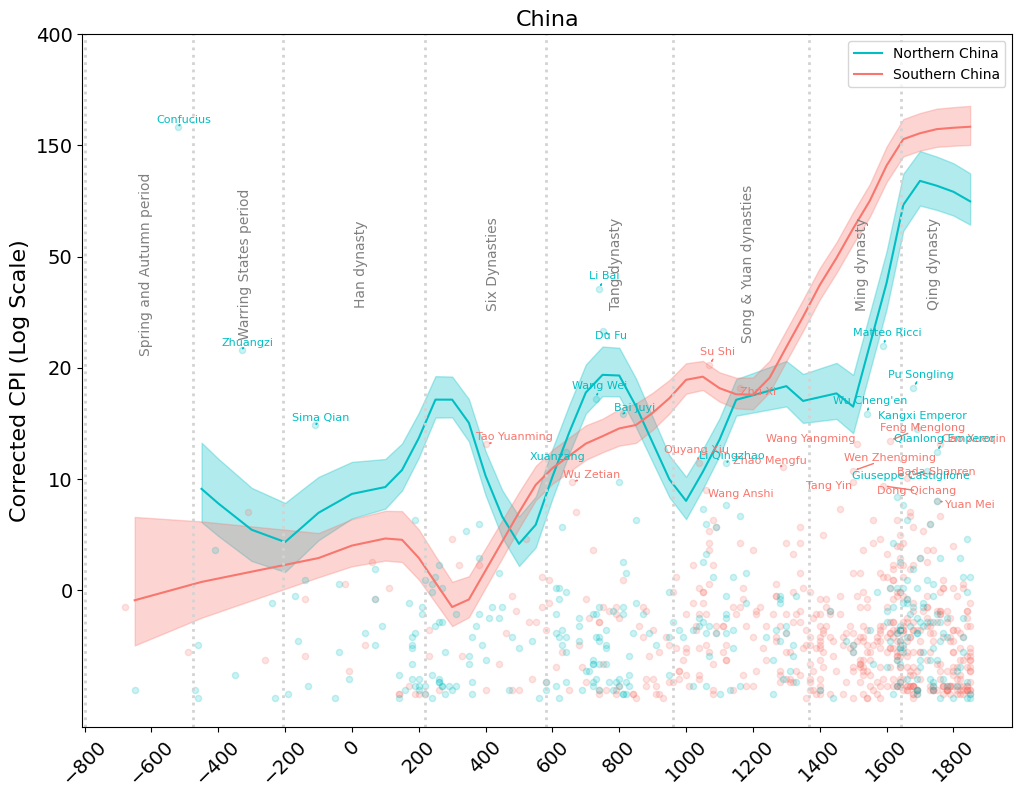

In [36]:
plot_figures(region_name_1="Northern China", 
        region_name_2='Southern China',
            max_year = 1850, 
            min_year = -800, 
            title='China',
            period_data =chinese_period_data, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = True)

In [37]:
list(set(df_cultura.region_name))

['German world',
 'Indian world',
 'Nordic countries',
 'Northwestern Europe',
 'Korea',
 'Western Europe',
 'Southern Japan',
 'Central Europe',
 'United Kingdom',
 'Chinese world',
 'Persian world',
 'Latin World',
 'Greek World',
 'Portugal',
 'Japan',
 'Southern China',
 'Other',
 'Low countries',
 'Spain',
 'Italy',
 'East Slavic',
 'Northern China',
 'Northern Japan',
 'Southwestern Europe',
 'MENA',
 'Arabic world',
 'France']

### Plot Western Europe

In [38]:
plot = False

if plot:

    from dotenv import load_dotenv
    import sqlite3
    import os

    load_dotenv()

    DB_PATH = os.getenv("DB_PATH")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    df_western = df_cultura_original.copy()

    df_country = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
    df_country = df_country[df_country['country_name'].isin(['Tunisia', 'Morocco', 'Algeria'])]
    df_country = df_country[df_country['birthyear']<=535]

    df_western = df_western[~df_western['individual_wikidata_id'].isin(list(df_country['individual_wikidata_id']))]


    # remove individuals belonging to #before 500 to Tunisia, Morocco and Algeria

    df_western['N_est'] = df_western['f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_min']  =  df_western['min_f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_max']  =  df_western['max_f0'] + df_western['f1'] + df_western['f2']# plus the individual

    df_cultura = df_western.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
    df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

    # Load individuals Data
    df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])


    # Add indiviudals not taken into account into the unseen-species model
    df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
    df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
    df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

    df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
    df_cultura = df_cultura.fillna(0)


    df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
    df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
    df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
    df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']



    regions_eu = ['Latin World',
    'Portugal',
    'Italy',
    #  'Greek World',
    'Spain',
    'Nordic countries',
    'German world',
    'Low countries',
    'France',
    'United Kingdom']

    df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]
    df_cultura['region_name'] = 'Western Europe'

    plot_figure(region_name = 'Western Europe', min_year = -800, max_year = 1850, period_data = None,  year_step = 100,  plot_original_trend = False, fifty=True)

In [39]:
# or just add Italy, France

# British Islands (After 500 CE)
# France (After 500 CE)
# German world (After 500 CE)
# Portugal (After 500 CE)
# Spain (after 500 CE)
# Italy (after 500 CE)
# Low countries (After 500 CE)
# Nordic countries (After 500 CE)